# Sheet 3

Handed in by Benny Bauer and Anton Schwarz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## 2 Projection Trick

(a)

In [2]:
# Load the data
xy = np.load('data03/data2d.npy')
labels = np.load('data03/labels.npy')

# TODO: Plot the data

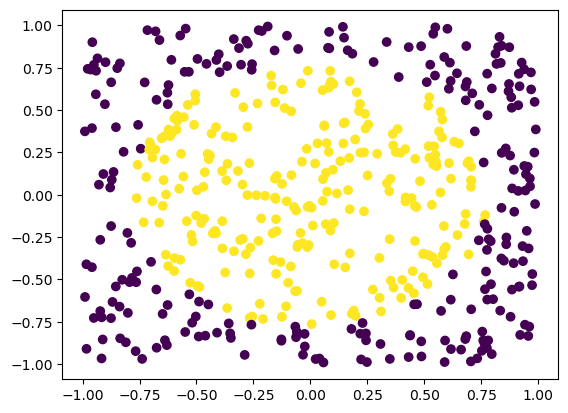

In [3]:
plt.scatter(xy[:,0], xy[:,1], c=labels);

This cannot be separated by a linear decision boundary in 2D because one class is fully enclosed in the other.

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
xy_train, xy_test, labels_train, labels_test = train_test_split(xy, labels, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import LogisticRegression
# TODO: fit logistic regression]
clf = LogisticRegression().fit(xy_train, labels_train)

# TODO: compute the accuracy
score = clf.score(xy_test, labels_test)
print(f"The score is {score:.2f}.")

# TODO: visualize the decision boundary
x_min, x_max = xy[:, 0].min() - .5, xy[:, 0].max() + .5
y_min, y_max = xy[:, 1].min() - .5, xy[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

The score is 0.54.


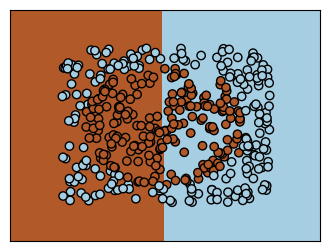

In [6]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Also plot the training points
plt.scatter(xy_train[:, 0], xy_train[:, 1], c=labels_train, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

### b)

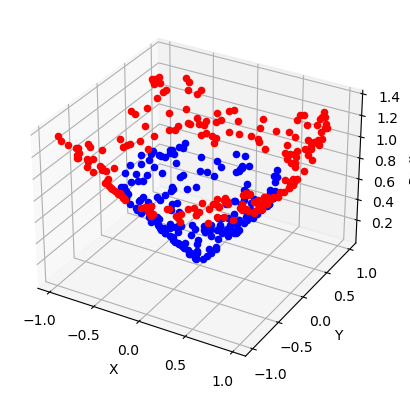

In [7]:
# TODO: Come up with a nonlinear tranformation for the third feature. Compute it and concatenate to the data.
def trafo3d(vec):
    # adds a third dimension to the data (radius)
    return np.column_stack([vec, np.sqrt(vec[:,0]**2 + vec[:,1]**2)])

xy_train_3d = trafo3d(xy_train) 

# TODO: Show the enhanced data, e.g. with a 3D scatter plot 
#       (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html).
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 0
while i < len(labels_train)-1:
    if labels_train[i] == 0:
        ax.scatter(xy_train_3d[i,0], xy_train_3d[i,1],xy_train_3d[i,2], color = 'red')
        i +=1
    if labels_train[i] == 1:
        ax.scatter(xy_train_3d[i,0], xy_train_3d[i,1],xy_train_3d[i,2], color = 'blue')
        i +=1
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Radius')

plt.show()

In [8]:
# TODO: again, fit and evaluate logistic regression
clf2 = LogisticRegression(random_state = 0).fit(xy_train_3d, labels_train)
pred2 = clf2.predict(trafo3d(xy_test))

print(clf2.score(trafo3d(xy_test), labels_test))

0.98


## 3) Linear regions of MLPs

(a)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# TODO: define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(2, 20)
        self.output_layer = nn.Linear(20, 1)

    # x represents our data
    def forward(self, x):
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Hidden layer: $W \in \mathbb{R}^{2 \times 20}$ and $b \in \mathbb{R}^{20}$;

Output layer: $W \in \mathbb{R}^{20 \times 1}$ and $b \in \mathbb{R}^{1}$

Sums up to 81 parameters (real numbers).

(b)

In [11]:
# indata = (torch.rand((500, 500, 2)) - 0.5) * 200

# Define the range of the grid
x = torch.linspace(-10, 10, 500)
y = torch.linspace(-10, 10, 500)

# Create the grid
xx, yy = torch.meshgrid(x, y)

# Stack the grids into a single tensor
indata = torch.stack((xx, yy), dim=2)

/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695391884920/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


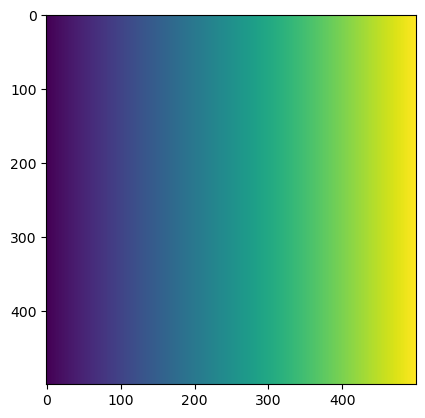

In [24]:
plt.imshow(indata.detach().numpy()[:,:,1])

In [13]:
my_nn = Net()

In [14]:
output = my_nn(indata)[:,:,0].detach().numpy()

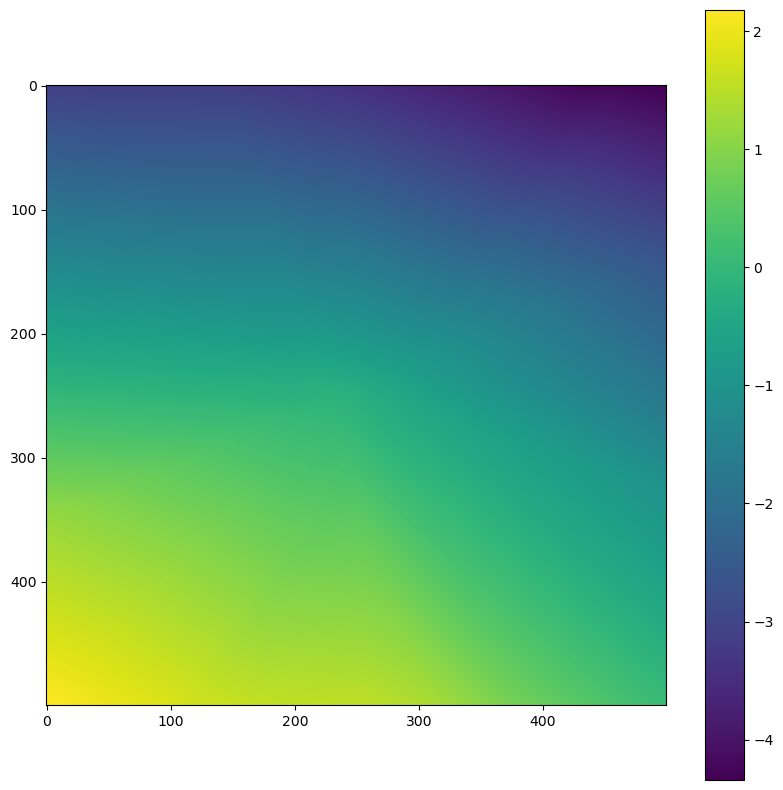

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='viridis')
plt.colorbar()

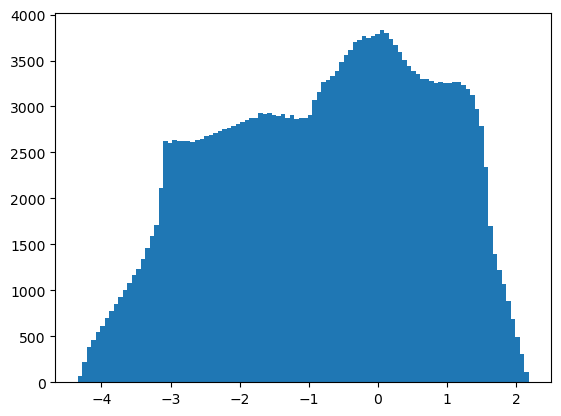

In [16]:
plt.hist(output.flatten(), bins=100);

(c)

In [17]:
[gradx, grady] = np.gradient(output)

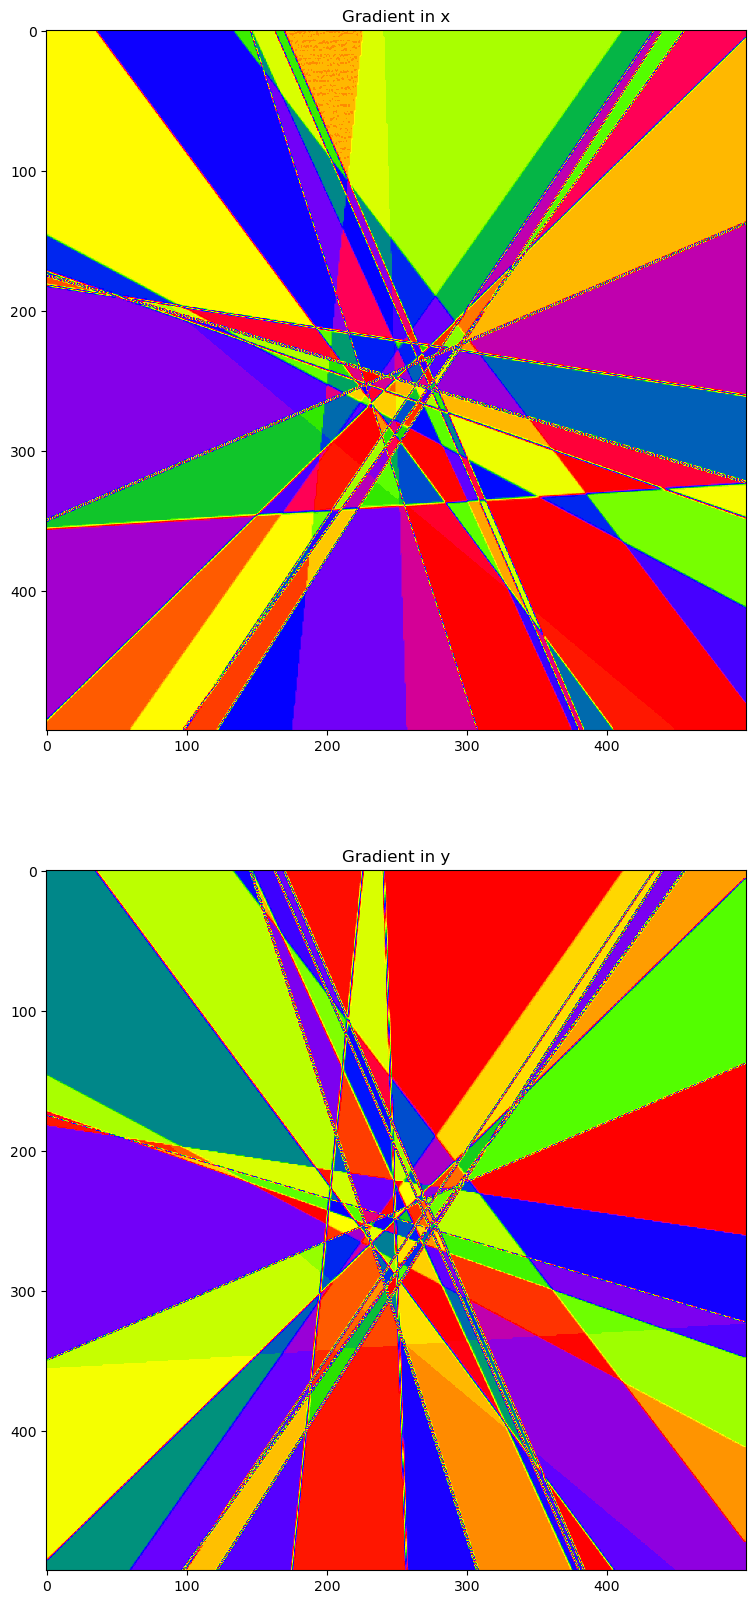

In [18]:
# Find the global min and max gradient values
f, axs = plt.subplots(2, 1, figsize=(10, 20))
# plot the gradients next to each other
axs[0].imshow(gradx, cmap='prism')
axs[0].set_title('Gradient in x')
axs[1].imshow(grady, cmap='prism')
axs[1].set_title('Gradient in y')

plt.show()

We observe that there is a grid-like pattern of lighter areas. We do not know the values of the elements on this pattern because 'prism' is a repeating colourmap. It is also interesting to note that the probability distribution of the gradients peaks at 0 and tapers off in a weird shape that is *not* gaussian.

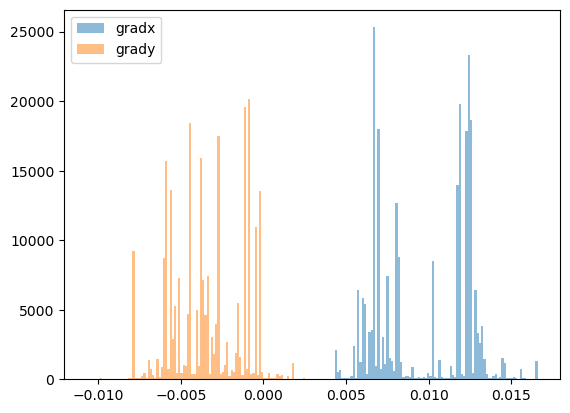

In [19]:
plt.hist(gradx.flatten(), bins=100, alpha=0.5, label='gradx');
plt.hist(grady.flatten(), bins=100, alpha=0.5, label='grady');
plt.legend()

(d)

In [20]:
# TODO: define NN architecture
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 5)
        self.hidden_layer_2 = nn.Linear(5, 5)
        self.hidden_layer_3 = nn.Linear(5, 5)
        self.hidden_layer_4 = nn.Linear(5, 5)
        self.output_layer = nn.Linear(5, 1)

    # x represents our data
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        x = self.hidden_layer_4(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

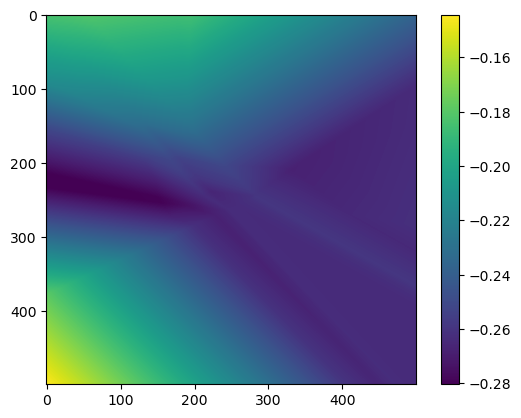

In [21]:
# TODO: instantiate the model and make the visualizations as requested in the task
my_deepnn = DeepNet()
output = my_deepnn(indata)[:,:,0].detach().numpy()
plt.imshow(output, cmap='viridis')
plt.colorbar()


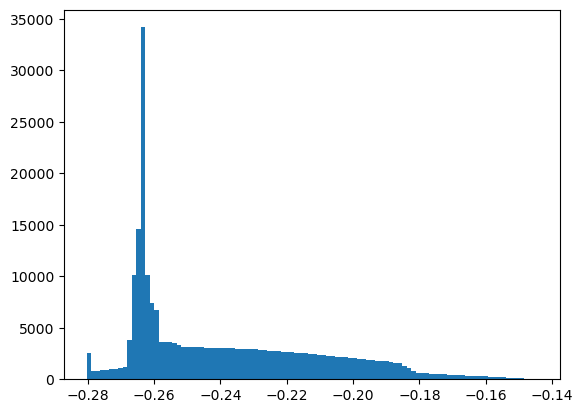

In [22]:
plt.hist(output.flatten(), bins=100);

Not much has changed compared to the shallow model. We have to note that the histogram of values is much more erratic for the deeper model than for the shallow one, the differences in the value distribution are quite pronounced here.